In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

In [2]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [3]:
# Construct the system
C = Ca40(["S-1/2", "D-1/2"])
L1 = Laser(); L1.pointing = [(1, 1.0), (2, 1.0)]
L2 = Laser(); L2.pointing = [(1, 1.0), (2, 1.0)]
chain = LinearChain(ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=2.5e5), vibrational_modes=(;z=[1]))
T = Trap(configuration=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim /Users/josephbroz/.julia/packages/IonSim/fbKtL/src/ion_configurations.jl:160


In [4]:
mode = T.configuration.vibrational_modes.z[1]

# Set the laser parameters
ϵ = 10e3
d = 350  # corrects for AC stark shift from single-photon coupling to sidebands
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
L1.Δ = Δf + mode.ν + ϵ - d
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - mode.ν - ϵ + d
L2.k = ẑ
L2.ϵ = x̂

η = abs(get_η(mode, L1, C))
pi_time = η / ϵ  # setting 'resonance' condition: ηΩ = 1/2ϵ
Efield_from_pi_time!(pi_time, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_pi_time!(pi_time, T, 2, 1, ("S-1/2", "D-1/2"));

In [5]:
# Set the dimension of the vibrational mode
mode.N = 10;

In [6]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);  # setup the Hamiltonian

In [7]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, ionstate(T, "S-1/2", "S-1/2") ⊗ fockstate(mode, 0), h);

  9.652071 seconds (39.58 M allocations: 2.037 GiB, 5.70% gc time)


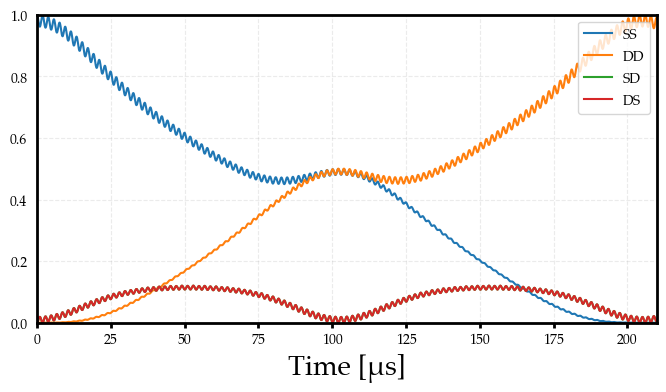

In [8]:
SS = expect(ionprojector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ionprojector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ionprojector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ionprojector(T, "D-1/2", "S-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SS[1:step:end], label="SS")
plt.plot(tout[1:step:end], DD[1:step:end], label="DD")
plt.plot(tout[1:step:end], SD[1:step:end], label="SD")
plt.plot(tout[1:step:end], DS[1:step:end], label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

In [9]:
L1.ϕ = t -> π;

In [10]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);

In [11]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:210, ionstate(T, "S-1/2", "S-1/2") ⊗ fockstate(mode, 0), h);

  0.178045 seconds (3.62 M allocations: 141.363 MiB, 11.31% gc time)


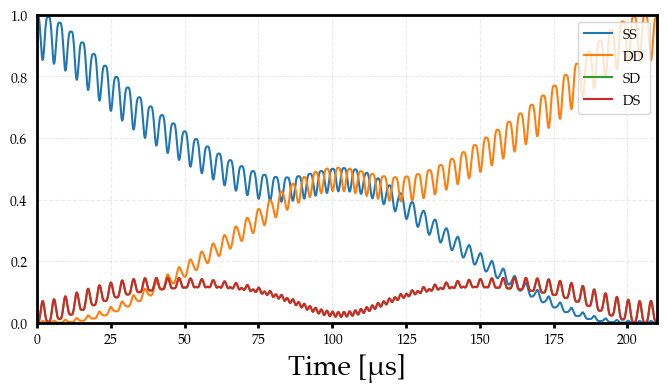

In [12]:
SS = expect(ionprojector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ionprojector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ionprojector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ionprojector(T, "D-1/2", "S-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SS[1:step:end], label="SS")
plt.plot(tout[1:step:end], DD[1:step:end], label="DD")
plt.plot(tout[1:step:end], SD[1:step:end], label="SD")
plt.plot(tout[1:step:end], DS[1:step:end], label="DS")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

In [13]:
E = Efield_from_pi_time(pi_time, T, 1, 1, ("S-1/2", "D-1/2"))

# Simple amplitude ramping function
function Ω(t)
    if t < 20
        return E * sin(2π * t / 80)^2
    elseif t > 200
        return E * cos(2π * (t - 200) / 80)^2
    else
        E
    end
end;

In [14]:
L1.E = t -> Ω(t)
L2.E = t -> Ω(t);

In [15]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=Inf);

In [16]:
@time tout, sol = timeevolution.schroedinger_dynamic(0:0.1:220, ionstate(T, "S-1/2", "S-1/2") ⊗ fockstate(mode, 0), h);

  0.222011 seconds (4.82 M allocations: 163.144 MiB, 8.50% gc time)


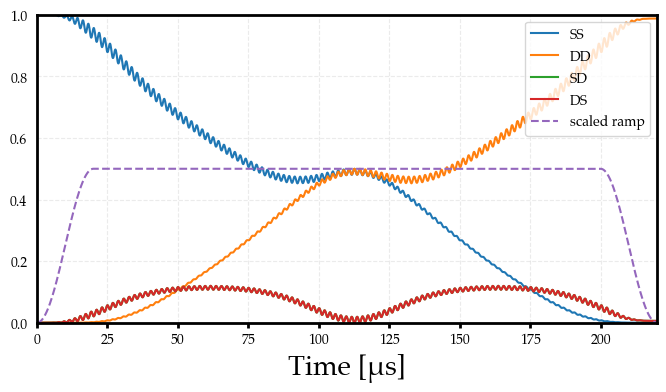

In [17]:
SS = expect(ionprojector(T, "S-1/2", "S-1/2"), sol)
DD = expect(ionprojector(T, "D-1/2", "D-1/2"), sol)
SD = expect(ionprojector(T, "S-1/2", "D-1/2"), sol)
DS = expect(ionprojector(T, "D-1/2", "S-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SS[1:step:end], label="SS")
plt.plot(tout[1:step:end], DD[1:step:end], label="DD")
plt.plot(tout[1:step:end], SD[1:step:end], label="SD")
plt.plot(tout[1:step:end], DS[1:step:end], label="DS")
plt.plot(tout, @.(Ω(tout) / 2E), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");